In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [2]:
DATA_SET_PATH = "C:/Users/Anwender/Desktop/MLPC_project"

metadata = pd.read_csv(os.path.join(DATA_SET_PATH, 'metadata.csv'))
files = metadata["filename"]

features_dir = 'audio_features'
labels_dir = 'labels'
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']


def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        votes = np.array(frame_labels)
        vote_sum = np.sum(votes)
        # Majority vote (≥ 50%)
        __y.append(int(vote_sum >= len(votes) / 2))
    return __y

def read_files(file_names, num_to_read=1000):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]: #we are not loading the entire dataset due to processing time
        if not os.path.exists(os.path.join(DATA_SET_PATH, features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(DATA_SET_PATH, features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(DATA_SET_PATH, labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(_y)
    X_train = np.concatenate(X_train)
    
    return X_train, convert_y_dict_to_array(Y_train, categories)

def convert_y_dict_to_array(y_dict, categories):
    y_array = np.zeros((len(y_dict[categories[0]]), len(categories)), dtype=int)
    for i, c in enumerate(categories):
        y_array[:, i] = y_dict[c]
    return y_array

nf = len(files)
sampled_files = files.sample(nf, random_state=0)

# train set 70%, val set 20%, test set 10% --> could also val, test = 15 %
train_files = sampled_files[:int(nf*0.7)]
val_files = sampled_files[int(nf*0.7):int(nf*0.9)]
test_files = sampled_files[int(nf*0.9):]

In [3]:
file_fraction = 0.1
X_train, Y_train = read_files(train_files, num_to_read=int(len(train_files)*file_fraction))
X_val, Y_val = read_files(val_files, num_to_read=int(len(val_files)*file_fraction))
X_test, Y_test = read_files(test_files, num_to_read=int(len(test_files)*file_fraction))

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# reduce size for testing
x_train, y_train = X_train_scaled[:50000], Y_train[:50000]
x_val, y_val = X_val_scaled[:5000], Y_val[:5000]
#x_train, y_train = X_train_scaled, Y_train
#x_val, y_val = X_val_scaled, Y_val

# TODO maybe stratify?

### Notably, the MultiLabelBaseline classifier in data-split_evaluation.ipynb is very bad, averaging the f1 scores leads to a misleadingly high score. A better baseline is needed.

# Experiments

## KNN

c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=1:
    val macro f1 score: 0.2035
    val weighted f1 score: 0.5142
    val sampled f1 score: 0.5275


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=5:
    val macro f1 score: 0.1838
    val weighted f1 score: 0.4862
    val sampled f1 score: 0.5059


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=10:
    val macro f1 score: 0.1831
    val weighted f1 score: 0.4844
    val sampled f1 score: 0.5008


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=20:
    val macro f1 score: 0.1839
    val weighted f1 score: 0.4858
    val sampled f1 score: 0.5015


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=100:
    val macro f1 score: 0.1777
    val weighted f1 score: 0.4832
    val sampled f1 score: 0.4874


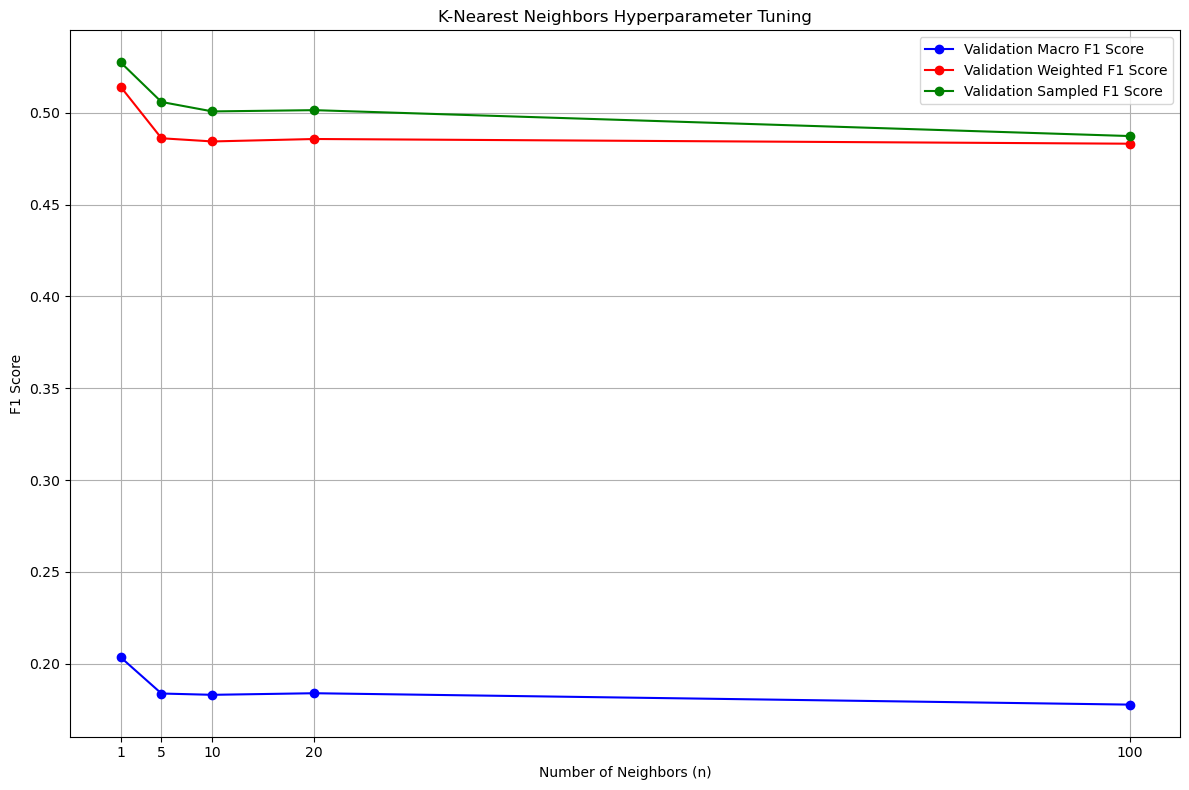

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors_list = [1, 5, 10, 20, 100] # n=1 heavily overfits, train f1=1.0
knn_val_macro_scores = []
knn_val_weighted_scores = []
knn_val_sampled_scores = []

for n in n_neighbors_list:
    knn_model_n = OneVsRestClassifier(KNeighborsClassifier(n))
    knn_model_n.fit(x_train, y_train)
    print(f'knn with n={n}:')
    
    knn_val_pred = knn_model_n.predict(x_val)
    knn_val_f1_m = f1_score(y_val, knn_val_pred, average='macro', zero_division=0)
    knn_val_macro_scores.append(knn_val_f1_m)
    print(f'    val macro f1 score: {knn_val_f1_m:.4f}')

    knn_val_f1_w = f1_score(y_val, knn_val_pred, average='weighted', zero_division=0)
    knn_val_weighted_scores.append(knn_val_f1_w)
    print(f'    val weighted f1 score: {knn_val_f1_w:.4f}')

    knn_val_f1_s = f1_score(y_val, knn_val_pred, average='samples', zero_division=0)
    knn_val_sampled_scores.append(knn_val_f1_s)
    print(f'    val sampled f1 score: {knn_val_f1_s:.4f}')
    
    # knn_train_pred = knn_model_n.predict(x_train)
    # knn_train_f1 = f1_score(y_train, knn_train_pred, average='macro')
    # print(f'    train macro f1 score: {knn_train_f1}')

plt.figure(figsize=(12, 8))
plt.plot(n_neighbors_list, knn_val_macro_scores, marker='o', label='Validation Macro F1 Score', color='blue')
plt.plot(n_neighbors_list, knn_val_weighted_scores, marker='o', label='Validation Weighted F1 Score', color='red')
plt.plot(n_neighbors_list, knn_val_sampled_scores, marker='o', label='Validation Sampled F1 Score', color='green')
plt.xlabel('Number of Neighbors (n)')
plt.ylabel('F1 Score')
plt.title('K-Nearest Neighbors Hyperparameter Tuning')
plt.xticks(n_neighbors_list)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('knn_hyperparameter_tuning.png')

## Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

max_depth_list = [1, 5, 10, 20, None]  # None means no max depth (full tree)
dt_val_macro_scores = []
dt_val_weighted_scores = []
dt_val_sampled_scores = []

for depth in max_depth_list:
    dt_model = OneVsRestClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_split=1000, min_samples_leaf=100, random_state=0))
    dt_model.fit(x_train, y_train)
    print(f'Decision Tree with max_depth={depth}:')
    
    dt_val_pred = dt_model.predict(x_val)
    dt_val_f1_m = f1_score(y_val, dt_val_pred, average='macro', zero_division=0)
    dt_val_macro_scores.append(dt_val_f1_m)
    print(f'    val macro f1 score: {dt_val_f1_m:.4f}')

    dt_val_f1_w = f1_score(y_val, dt_val_pred, average='weighted', zero_division=0)
    dt_val_weighted_scores.append(dt_val_f1_w)
    print(f'    val weighted f1 score: {dt_val_f1_w:.4f}')

    dt_val_f1_s = f1_score(y_val, dt_val_pred, average='samples', zero_division=0)
    dt_val_sampled_scores.append(dt_val_f1_s)
    print(f'    val sampled f1 score: {dt_val_f1_s:.4f}')

plt.figure(figsize=(12, 8))
plt.plot([str(d) for d in max_depth_list], dt_val_macro_scores, marker='o', label='Validation Macro F1 Score', color='blue')
plt.plot([str(d) for d in max_depth_list], dt_val_weighted_scores, marker='o', label='Validation Weighted F1 Score', color='red')
plt.plot([str(d) for d in max_depth_list], dt_val_sampled_scores, marker='o', label='Validation Sampled F1 Score', color='green')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('Decision Tree Hyperparameter Tuning')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('dt_hyperparameter_tuning.png')

c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


## SVM

In [ ]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='sklearn')

kernel_list = ['linear', 'rbf']
C_list = [0.1, 1, 10]
# gamma_list = ['scale', 'auto'] does not make a difference
svm_val_macro_scores = {'linear': [], 'rbf': []}
svm_val_weighted_scores = {'linear': [], 'rbf': []}
svm_val_sampled_scores = {'linear': [], 'rbf': []}

for kernel in kernel_list:
    for C in C_list:
        # svm_model_n = OneVsRestClassifier(SVC(kernel=kernel, C=C, gamma='scale', max_iter=1000)) if kernel != 'linear' else OneVsRestClassifier(LinearSVC(C=C, max_iter=1000))
        svm_model_n = OneVsRestClassifier(SVC(kernel=kernel, C=C, gamma='scale', max_iter=1000))
        svm_model_n.fit(x_train, y_train)
        print(f'SVM with kernel={kernel}, C={C}:')
        
        svm_val_pred = svm_model_n.predict(x_val)
        svm_val_f1 = f1_score(y_val, svm_val_pred, average='macro', zero_division=0)
        svm_val_macro_scores[kernel].append(svm_val_f1)
        print(f'    val macro f1 score: {svm_val_f1:.4f}')
        
        svm_val_f1_w = f1_score(y_val, svm_val_pred, average='weighted', zero_division=0)
        svm_val_weighted_scores[kernel].append(svm_val_f1_w)
        print(f'    val weighted f1 score: {svm_val_f1_w:.4f}')

        svm_val_f1_s = f1_score(y_val, svm_val_pred, average='samples', zero_division=0)
        svm_val_sampled_scores[kernel].append(svm_val_f1_s)
        print(f'    val sampled f1 score: {svm_val_f1_s:.4f}')

svm_results = []
for kernel in kernel_list:
    for i, C in enumerate(C_list):
        svm_results.append({
            'kernel': kernel,
            'C': C,
            'val_macro_f1': svm_val_macro_scores[kernel][i],
            'val_weighted_f1': svm_val_weighted_scores[kernel][i],
            'val_sampled_f1': svm_val_sampled_scores[kernel][i]
        })
svm_results_sorted = sorted(svm_results, key=lambda r: r['val_weighted_f1'] + r['val_macro_f1'] + r['val_sampled_f1'], reverse=True)
labels = [f'kernel={r["kernel"]}, C={r["C"]}' for r in svm_results_sorted]
macro_f1_scores = [r['val_macro_f1'] for r in svm_results_sorted]
weighted_f1_scores = [r['val_weighted_f1'] - r['val_macro_f1'] for r in svm_results_sorted]
sampled_f1_scores = [r['val_sampled_f1'] - r['val_weighted_f1'] - r['val_macro_f1'] for r in svm_results_sorted]

plt.figure(figsize=(12, 8))
x = range(len(labels))
plt.bar(x, macro_f1_scores, label='Macro F1 Score', color='blue')
plt.bar(x, weighted_f1_scores, bottom=macro_f1_scores, label='Weighted F1 Score', color='red')
plt.bar(x, sampled_f1_scores, bottom=np.array(macro_f1_scores) + np.array(weighted_f1_scores), label='Sampled F1 Score', color='green')
plt.xticks(x, labels, rotation=90, fontsize=8)
plt.ylabel('F1 Score')
plt.title('SVM Hyperparameter Tuning')
plt.legend()
plt.tight_layout()
plt.savefig('svm_hyperparameter_tuning.png')

SVM with kernel=linear, C=0.1:
    val macro f1 score: 0.1914
    val weighted f1 score: 0.4861
    val sampled f1 score: 0.4636


## NN

In [ ]:
hidden_layers_list = [(128, ), (256, 128), (512, 256)] # (512, 256, 128) heavily overfits
activation_list = ['relu', 'tanh']
alpha_list = [0.0001, 0.001, 0.01]

results = []
for hidden_layers in hidden_layers_list:
    for activation in activation_list:
        for alpha in alpha_list:
            mlp_model = sklearn.neural_network.MLPClassifier(
                hidden_layer_sizes=hidden_layers,
                activation=activation,
                alpha=alpha,
                solver='adam',
                max_iter=100,
                random_state=0,
                verbose=False
            )

            mlp_model.fit(x_train, y_train)
            mlp_val_pred = mlp_model.predict(x_val)
            mlp_val_f1_m = f1_score(y_val, mlp_val_pred, average='macro', zero_division=0)
            mlp_val_f1_w = f1_score(y_val, mlp_val_pred, average='weighted', zero_division=0)
            mlp_val_f1_s = f1_score(y_val, mlp_val_pred, average='samples', zero_division=0)

            print(f'Neural Network with hidden layers={hidden_layers}, activation={activation}, alpha={alpha}:')
            print(f'    val macro f1 score: {mlp_val_f1_m:.4f}')
            print(f'    val weighted f1 score: {mlp_val_f1_w:.4f}')
            print(f'    val sampled f1 score: {mlp_val_f1_s:.4f}')
            results.append({
                'hidden_layers': hidden_layers,
                'activation': activation,
                'alpha': alpha,
                'val_macro_f1': mlp_val_f1_m,
                'val_weighted_f1': mlp_val_f1_w,
                'val_sampled_f1': mlp_val_f1_s
            })

n_results_sorted = sorted(results, key=lambda x: x['val_weighted_f1'] + x['val_weighted_f1'], reverse=True)
labels = [f'{r['hidden_layers']}, {r['activation']}, {r['alpha']}' for r in n_results_sorted]
macro_f1_scores = [r['val_macro_f1'] for r in n_results_sorted]
weighted_f1_scores = [r['val_weighted_f1'] - r['val_macro_f1'] for r in n_results_sorted]  # stacked above macro
sampled_f1_scores = [r['val_sampled_f1'] - r['val_weighted_f1'] - r['val_macro_f1'] for r in n_results_sorted]
plt.figure(figsize=(12, 6))
x = range(len(labels))
plt.bar(x, macro_f1_scores, label='Macro F1 Score', color='blue')
plt.bar(x, weighted_f1_scores, bottom=macro_f1_scores, label='Weighted F1 Score', color='red')
plt.bar(x, sampled_f1_scores, bottom=np.array(macro_f1_scores) + np.array(weighted_f1_scores), label='Sampled F1 Score', color='green')
plt.xticks(x, labels, rotation=90, fontsize=8)
plt.xlabel("Hyperparameter combinations")
plt.ylabel("Validation F1 Score")
plt.title("Neural Network Hyperparameter Tuning")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("nn_hyperparameter_tuning.png")

c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with hidden layers=(128,), activation=relu, alpha=0.0001:
    val macro f1 score: 0.1742
    val weighted f1 score: 0.4640


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with hidden layers=(128,), activation=relu, alpha=0.001:
    val macro f1 score: 0.1845
    val weighted f1 score: 0.4851


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with hidden layers=(128,), activation=relu, alpha=0.01:
    val macro f1 score: 0.1842
    val weighted f1 score: 0.4787


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with hidden layers=(128,), activation=tanh, alpha=0.0001:
    val macro f1 score: 0.1970
    val weighted f1 score: 0.5081


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with hidden layers=(128,), activation=tanh, alpha=0.001:
    val macro f1 score: 0.2154
    val weighted f1 score: 0.5348
MLP with hidden layers=(128,), activation=tanh, alpha=0.01:
    val macro f1 score: 0.2301
    val weighted f1 score: 0.5588
MLP with hidden layers=(256, 128), activation=relu, alpha=0.0001:
    val macro f1 score: 0.1843
    val weighted f1 score: 0.4805
MLP with hidden layers=(256, 128), activation=relu, alpha=0.001:
    val macro f1 score: 0.1756
    val weighted f1 score: 0.4673
MLP with hidden layers=(256, 128), activation=relu, alpha=0.01:
    val macro f1 score: 0.1878
    val weighted f1 score: 0.4674


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with hidden layers=(256, 128), activation=tanh, alpha=0.0001:
    val macro f1 score: 0.1886
    val weighted f1 score: 0.5142
MLP with hidden layers=(256, 128), activation=tanh, alpha=0.001:
    val macro f1 score: 0.2328
    val weighted f1 score: 0.5812
MLP with hidden layers=(256, 128), activation=tanh, alpha=0.01:
    val macro f1 score: 0.2075
    val weighted f1 score: 0.5356


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with hidden layers=(512, 256), activation=relu, alpha=0.0001:
    val macro f1 score: 0.1709
    val weighted f1 score: 0.4766
MLP with hidden layers=(512, 256), activation=relu, alpha=0.001:
    val macro f1 score: 0.1826
    val weighted f1 score: 0.4893


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP with hidden layers=(512, 256), activation=relu, alpha=0.01:
    val macro f1 score: 0.1735
    val weighted f1 score: 0.4750


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP with hidden layers=(512, 256), activation=tanh, alpha=0.0001:
    val macro f1 score: 0.2429
    val weighted f1 score: 0.5881


## evaluate models with best parameters on test set

In [ ]:
print('reading data...')
file_fraction = 1
X_train, Y_train = read_files(train_files, num_to_read=int(len(train_files)*file_fraction))
X_val, Y_val = read_files(val_files, num_to_read=int(len(val_files)*file_fraction))
X_test, Y_test = read_files(test_files, num_to_read=int(len(test_files)*file_fraction))

print('scaling data...')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


del X_train, X_test # free memory

reading data...


In [ ]:
print('knn with n=1:')
knn_best_model = sklearn.neighbors.KNeighborsClassifier(1)
print(f'    training...')
knn_best_model.fit(X_train_scaled, Y_train)
print(f'    evaluating...')
knn_test_pred = knn_best_model.predict(X_test_scaled)
knn_test_m_f1 = f1_score(Y_test, knn_test_pred, average='macro')
knn_test_w_f1 = f1_score(Y_test, knn_test_pred, average='weighted')
knn_test_s_f1 = f1_score(Y_test, knn_test_pred, average='samples')
print(f"    knn test macro f1 score: {knn_test_m_f1:.4f}")
print(f"    knn test weighted f1 score: {knn_test_w_f1:.4f}")
print(f"    knn test sampled f1 score: {knn_test_s_f1:.4f}")
knn_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, knn_test_pred)
knn_test_acc = accuracy_score(Y_test, knn_test_pred)
print(f"    knn test accuracy score: {knn_test_acc:.4f}")
print(f"    knn test balanced accuracy score: {knn_test_balanced_acc:.4f}")

knn with n=100:
     training...
     evaluating...
    knn test macro f1 score: 0.4992
    knn test weighted f1 score: 0.5577


In [ ]:
print('decision tree with max_depth=10:') # change to best depth
dt_best_model = sklearn.tree.DecisionTreeClassifier(max_depth=10)
print(f'    training...')
dt_best_model.fit(X_train_scaled, Y_train)
print(f'    evaluating...')
dt_test_pred = dt_best_model.predict(X_test_scaled)
dt_test_m_f1 = f1_score(Y_test, dt_test_pred, average='macro')
dt_test_w_f1 = f1_score(Y_test, dt_test_pred, average='weighted')
dt_test_s_f1 = f1_score(Y_test, dt_test_pred, average='samples')
print(f"    dt test macro f1 score: {dt_test_m_f1:.4f}")
print(f"    dt test weighted f1 score: {dt_test_w_f1:.4f}")
print(f"    dt test sampled f1 score: {dt_test_s_f1:.4f}")
dt_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, dt_test_pred)
dt_test_acc = accuracy_score(Y_test, dt_test_pred)
print(f"    dt test accuracy score: {dt_test_acc:.4f}")
print(f"    dt test balanced accuracy score: {dt_test_balanced_acc:.4f}")

In [ ]:
print('svm linear with c=0.1:')
svm_best_model = sklearn.svm.LinearSVC(C=0.1, max_iter=1000)
print('     training svm...')
svm_best_model.fit(X_train_scaled, Y_train)
print('     evaluating svm...')
svm_test_pred = svm_best_model.predict(X_test_scaled)
svm_test_m_f1 = f1_score(Y_test, svm_test_pred, average='macro')
svm_test_w_f1 = f1_score(Y_test, svm_test_pred, average='weighted')
print(f"    svm test macro f1 score: {svm_test_m_f1:.4f}")
print(f"    svm test weighted f1 score: {svm_test_w_f1:.4f}")
svm_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, svm_test_pred)
svm_test_acc = accuracy_score(Y_test, svm_test_pred)
print(f"    knn test accuracy score: {svm_test_acc:.4f}")
print(f"    knn test balanced accuracy score: {svm_test_balanced_acc:.4f}")

svm linear with c=0.1:
     training svm...


In [ ]:
print('nn with hidden layers (256, 128), activation tanh, alpha 0.01:')
nn_best_model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256, 128), activation='tanh', alpha=0.01, solver='adam', max_iter=100, random_state=0, verbose=False)
print(f'    training nn...')
nn_best_model.fit(X_train_scaled, Y_train)
print(f'    evaluating nn...')
nn_test_pred = nn_best_model.predict(X_test_scaled)
nn_test_m_f1 = f1_score(Y_test, nn_test_pred, average='macro')
nn_test_w_f1 = f1_score(Y_test, nn_test_pred, average='weighted')
nn_test_s_f1 = f1_score(Y_test, nn_test_pred, average='samples')
print(f"    nn test macro f1 score: {nn_test_m_f1:.4f}")
print(f"    nn test weighted f1 score: {nn_test_w_f1:.4f}")
print(f"    nn test sampled f1 score: {nn_test_s_f1:.4f}")
nn_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, nn_test_pred)
nn_test_acc = accuracy_score(Y_test, nn_test_pred)
print(f"     nn test accuracy score: {nn_test_acc:.4f}")
print(f"     nn test balanced accuracy score: {nn_test_balanced_acc:.4f}")

nn with hidden layers (256, 128), activation tanh, alpha 0.01:
     training nn...
